# ReMapping Blaueu's 1664 Terrarium Orbis


In [28]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imwrite
import numpy as np
from copy import deepcopy

In [29]:
blaueu1664 = imread('/Users/patrickfoley/map_projections/input_images/Blaeu_1664.jpg')

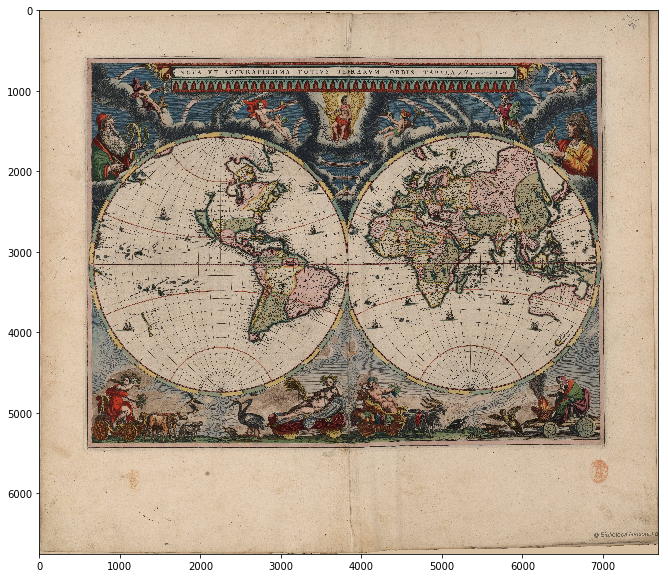

In [30]:
plt.figure(figsize=(14,10))
plt.imshow(blaueu1664)

Let's try to crop it, and try to crop the circles. 

In [31]:
print blaueu1664.shape

(6751, 7686, 3)


In [32]:
#cropped_blau = blaueu1664[700:5400, 600:7100, :]
#cropped_blau = blaueu1664[650:5400, 600:7000, :]
cropped_blau = blaueu1664[600:5400, 600:7000, :]

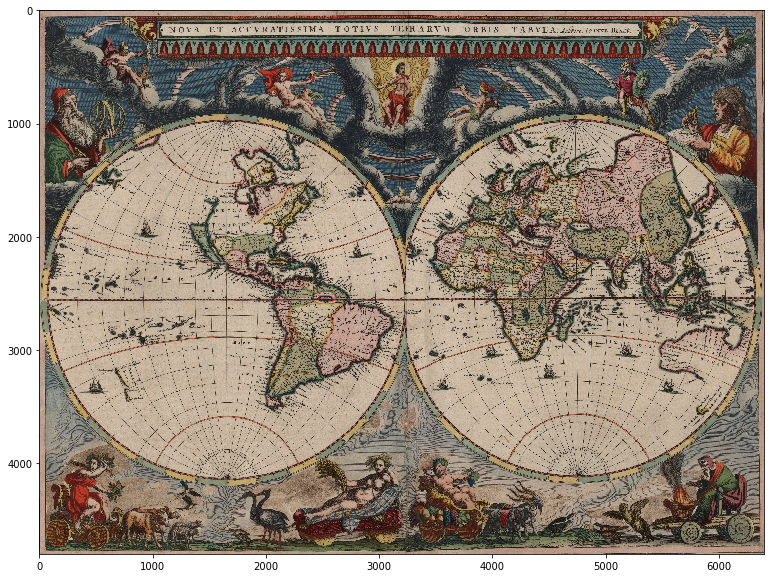

In [33]:
plt.figure(figsize=(14,10))
plt.imshow(cropped_blau)

Looks good!  Now let's get both hemispheres. 

In [34]:
def get_hemisphere(center, radius, base=cropped_blau):
    """Center is (x,y) pixels, radius is in pixels.
    Start from cropped."""
    cx, cy = center
    assert cx > radius
    assert cy > radius
    nxbase, nybase, _ = base.shape
    assert nxbase - cx > radius
    assert nybase - cy > radius
    square = deepcopy(base[(cx-radius):(cx+radius), (cy-radius):(cy+radius), :])
    #  Need to make other pixels black.  Or maybe not.  
    #  square is now shape r, r, 3
    npix = 2*radius + 1
    xs, ys = np.meshgrid(np.arange(0, npix-1), np.arange(0, npix-1))
    out_of_circle = (xs - (npix/2))**2 + (ys-(npix/2))**2 > radius**2
    square[xs[out_of_circle], ys[out_of_circle], :] = 0
    return square


In [35]:
western_hemisphere = get_hemisphere((2560, 1650), 1575)

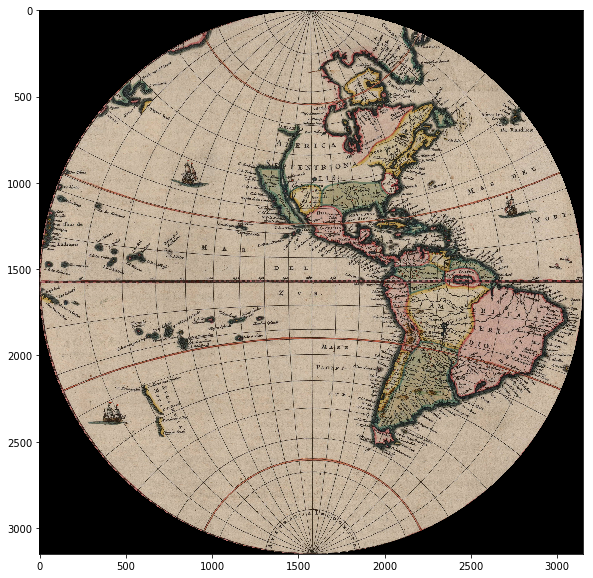

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(western_hemisphere)

# Test Images

In [108]:
other_w = deepcopy(western_hemisphere)


In [109]:
other_w.shape

(3150, 3150, 3)

In [110]:
other_w[400:1000, 1000:1100, :] = 1

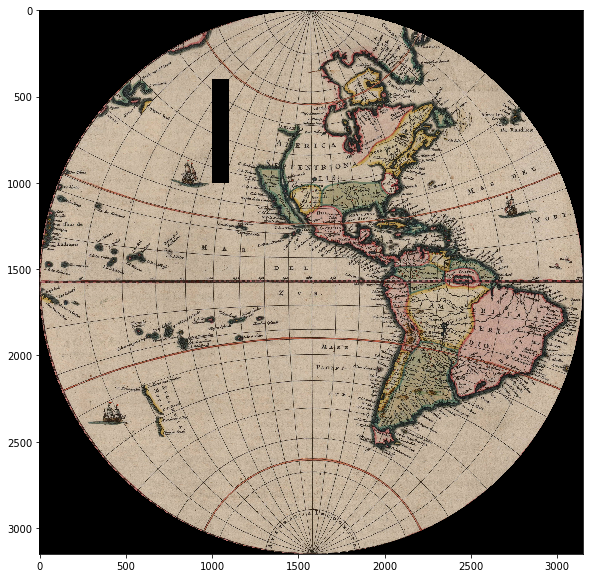

In [111]:
plt.figure(figsize=(10,10))
plt.imshow(other_w)



In [37]:
eastern_hemisphere = get_hemisphere((2550, 4750), 1575)

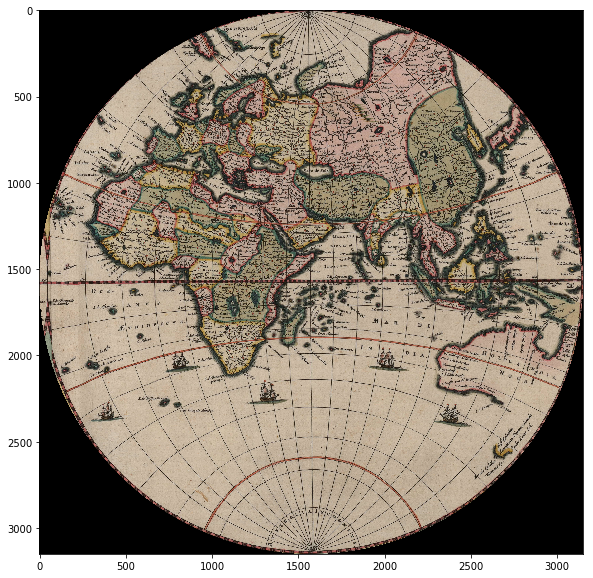

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(eastern_hemisphere)

For the Eastern hemisphere, there is a bit of a crease in the actual image that we won't be able to avoid.  This is going to cause some distortions, but that's ok.

<img src="blaueu_crease.png" alt="Crease on Page" style="width: 200px;"/>


Now let's determine the longitudes and latitudes in the Blaueu's map. 

I can't directly use the labels on the map, since they are not using London as the prime meridian.  Looks a bit west of Portugal, or further.  So I will just ballpark it. 

Let's say the center of the western hemisphere is, in longitude, midway b/w London (0 degrees) and 90 degrees, so we will put it at 45 East. Then we should have 45 East + 180 as the center of the Western. That puts us at 135 west. 

##  Mapping Pixels to Spatial Coordinates

I cheated and looked at [Wikipedia](https://en.wikipedia.org/wiki/Stereographic_projection
), which was very helpful.




Using $(x, y, z)$ for the sphere, and $(u, v)$ for pixels on the plane, we have:

\begin{eqnarray}
(u, v) &=& (\frac{x}{1-z}, \frac{y}{1-z}) \\
\psi &=& u^2 + v^2 \\
(x, y, z) &=& (\frac{2 u}{1 + \psi}, \frac{2 v}{1 + \psi}, \frac{-1 + \psi}{1 + \psi}) \\
\end{eqnarray}

I believe this sets things up where positive z is the north pole (center of eastern hemisphere in blauau's map) and negative the south (western).  

This is for the stereographic projection of a unit sphere centered at the origin from its North pole to the plane of the equator.  We will need to pull pixels into spatial coordinates, then rotate, then we'll have actual spatial coordinates we can use to map to longitude and latitude. 

We also will have to manage _two_ stereographic projections.  One for northern (eastern) and one for southern (western).  

### Making a Mask / Array of Pixels

We will need some set of pixels to manipulate, which might be a bit tough.  We need to get an array of `(u, v)` s.t. `u**2 + v**2 <= r**2`.  We'll center the hemisphere to start, so it should appear to go from `[-r, -r]` at bottom left to `[r, r]` at top right. 

This is maybe wrong.  I think top left is 0,0, bottom right is N, N. 

In [41]:
hemisphere_pixel_radius = 1575

Note that every time we index into the hemisphere image, we'll need to add back in the radius. 

In [44]:
(1.0 * len(us)) / ((2.0*p_rad)*(2.0*p_rad))

0.7853824137062232

In [177]:
us, vs = np.meshgrid(np.arange(-p_rad, p_rad), np.arange(-p_rad, p_rad))
us = us.flatten().astype(float)
vs = vs.flatten().astype(float)

# This is not actually those in the circle.  u,v are not 
# arranged cartesian..ly.  
in_circle = [u**2 + v**2 < hemisphere_pixel_radius**2 
            for u, v in zip(us, vs)]

us = us[in_circle]
vs = vs[in_circle]

# these are now -r to r s.t. sum r2 < R.

us = us + p_rad
vs = vs + p_rad
#. these are now 0 to 2r, 0 to 2r s.t (u-r)^2 + (v-r)^2 < R2

In [178]:
testmask = deepcopy(eastern_hemisphere)

In [179]:
print testmask.shape

(3150, 3150, 3)


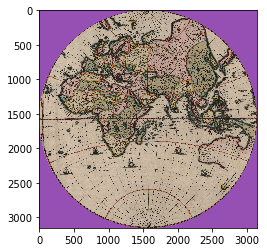

In [180]:
testmask[:, :, 0] = 150
testmask[:, :, 1] = 80
testmask[:, :, 2] = 180
# just to show it's doing something

testmask[us.astype(int), vs.astype(int), 0] = eastern_hemisphere[us.astype(int), vs.astype(int), 0]
testmask[us.astype(int), vs.astype(int), 1] = eastern_hemisphere[us.astype(int), vs.astype(int), 1]
testmask[us.astype(int), vs.astype(int), 2] = eastern_hemisphere[us.astype(int), vs.astype(int), 2]
plt.imshow(testmask)

In [181]:
n_per_hemisphere = len(us)
us = np.tile(us, 2)
vs = np.tile(vs, 2)
NSs = np.repeat(np.array([-1, 1]), n_per_hemisphere)
NSs = np.array(NSs)

So now, for the eastern hemisphere, we have arrays of u and v that index from [0, 0] up through [radius, 0], etc... and only include the pixels within the circle.  

### Transforming the Pixels

So I think this is doable, I just have to do both hemispheres at the same time, and then keep track of `(u, v, N/S)` where the third entry is `-1` or `1` showing which hemisphere we're on, and the canonical orientation is `1` for the Northern hemisphere and `-1` for the Southern.  We'll just have to deal w/ Blaueu's map not being set at that. 

Hm, another issue is that, in general, a sterographic projection can show more than a hemisphere.  Some maps use a sterographic projection and show a hemisphere + 30 or so degrees.


<img src="1200px-Stereographic_projection_SW.JPG" alt="[An example from Wikipedia w/ North pole at origin extending to 30* South" style="width: 240px;"/>

Neat!  So if we actually make something able to display generic sterographics, we could set up a map with the north pole (or wherever) as the center, a ring for the south pole, and then another huge ring later for the north pole again.  Maybe.

So let me check my mappings here and make sure my pixels won't be going to the southern hemisphere.

Then the $z$ axis is $\frac{-1 + u^2 + v^2}{1 + u^2 + v^2}$, so the equator is at $u^2 + v^2 = 1$.  In our case, this doesn't happen, so I think we are OK.

So I think the only thing we are missing is an inverse, to go from xyz to (u,v,N/S).  Let's define new functions that know that we are using two sterographic projections, one for each hemisphere, rather than one.

In [182]:
z90 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

In [183]:
z90

array([[ 0, -1,  0],
       [ 1,  0,  0],
       [ 0,  0,  1]])

In [184]:
z180 = np.matmul(z90, z90)

In [185]:
z180

array([[-1,  0,  0],
       [ 0, -1,  0],
       [ 0,  0,  1]])

In [196]:
def uv_to_st(u, v):
    """Images are not arranged how I want.  This remaps them.

    They start (call this u, v) with It is (y, x) and the top left is 0,0.
    top left      -  0, 0
    top right     -  0, N
    bottom left   -  N, 0
    bottom right  -  N, N
    these  also go 0 to 2r, 0 to 2r.
    
    Maybe I should first turn it from p1, p2 to u,v where it's x, y 
    and
      topleft     - 0, N
      topright    - N, N
      bottomleft  - 0, 0
      bottomright - N, 0
    should these be -r to r?
      
    pixels are [s, t, rgb]
    then x,y is [u, v, rgb]"""
    s = v - p_rad
    t = p_rad - u
    
    return s, t

In [219]:
def st_to_uv(s, t):
    """Images are not arranged how I want.  This remaps them.

    They start (call this u, v) with It is (y, x) and the top left is 0,0.
    top left      -  0, 0
    top right     -  0, N
    bottom left   -  N, 0
    bottom right  -  N, N
    
    Maybe I should first turn it from p1, p2 to u,v where it's x, y 
    and
      topleft     - 0, N
      topright    - N, N
      bottomleft  - 0, 0
      bottomright - N, 0
      
    pixels are [s, t, rgb]
    then x,y is [u, v, rgb]
    
    really s,t are in [0, 2r].  u,v (closer to xy) are -r,r."""
    print ' in st to uv'
    print 'range of s is {} to {}'.format(min(s), max(s))
    print 'range of t is {} to {}'.format(min(t), max(t))
    u = p_rad - t
    v = -(s - p_rad) #. ????  this should not work...
    print 'range of u is {} to {}'.format(min(u), max(u))
    print 'range of v is {} to {}'.format(min(v), max(v))

    
    return u, v

In [220]:
def st_to_xyz(s, t, NS, radius):
    """Spatial coordinates on unit sphere from pixel values and 
    map radius for a centered stereographic projection. Sterographic
    projection map is taken to go -r to r in pixels.
    
    u is -r to r, 
    v is -r to r
    NS is -1 (western hemisphere or southern) or 1(eastern or northern)
    -r,-r is bottom left.  
    
    NOTE:  Images are oriented kind of weird.  
        It is (y, x) and the top left is 0,0.
    top left      -  0, 0
    top right     -  0, N
    bottom left   -  N, 0
    bottom right  -  N, N
    
    Maybe I should first turn it from p1, p2 to u,v where it's x, y 
    and
      topleft     - 0, N
      topright    - N, N
      bottomleft  - 0, 0
      bottomright - N, 0
    """
    #assert all(s**2 + t**2 <= radius**2)
    assert all([ns in [-1,1] for ns in NS])
    # is it this or inverse?
    #  u, v = st_to_uv(s, t)
    
    x = s * 1.0 / radius
    y = t * 1.0 / radius
    pixnorm = x**2 + y**2
    
    #  Try instead rotating 3d. 
    #  Also you need to be careful - is u,v like x,y or how does indexing work?
    #  I want it to be like x,y. 
    return (NS * 2*x / (1 + pixnorm), 
            NS * 2*y / (1 + pixnorm),
            (NS * (-1 + pixnorm)) / (1 + pixnorm))

In [221]:
def xyz_to_st(x, y, z, radius):
    """Spatial coordinates on unit sphere from pixel values and 
    map radius for a centered stereographic projection. Sterographic
    projection map is taken to go -r to r in pixels"""
    # renormalize
    xyznorm = np.sqrt(x**2 + y**2 + z**2)
    assert (xyznorm <= 1.00001).all()
    x /= xyznorm
    y /= xyznorm
    z /= xyznorm

    #  Choose Hemisphere
    NS = 2.0 * np.greater(z, 0.0) - 1.0
    absz = np.abs(z)
    assert (abs(NS) <= 1.0001).all()
    assert (abs(NS) >= 0.9999).all()
    
    s = (x / (1 + absz))
    t = (y / (1 + absz))
    s = np.round(s * radius)
    t = np.round(t * radius)
    
    print 'range of s: {} to {}'.format(np.min(s), np.max(s))
    print 'range of t: {} to {}'.format(np.min(t), np.max(t))

    # This is for the opposite hemisphere
    #altU = np.greater(0, u)*(u) + np.greater(u, 0)*(radius - u)
    #altV = np.greater(0, v)*(v) + np.greater(v, 0)*(radius - v)
    altS = -s
    altT = -t

    #altV = radius - v
    s = np.greater(NS, 0) * s + np.greater(0, NS)*altS
    t = np.greater(NS, 0) * t + np.greater(0, NS)*altT

    print 'after alts'
    print 'range of s: {} to {}'.format(np.min(s), np.max(s))
    print 'range of t: {} to {}'.format(np.min(t), np.max(t))


    
    #  Outputs need to be indices, so NS should be
    #  0 for western, 1 for eastern.  
    return (s, t, NS)

I think my problem is the xy/st/uv translation.  I am thinking as though -x,-y or -s,-t, or -u,-v is bottom left.  but in numpy images, 0,0 is top left and 1,1 is bottom right. 

In [222]:
def img_test(rot_mat=np.eye(3)):
    #.\ Start with u, v
    full_array = np.array([western_hemisphere, eastern_hemisphere])
    new_full_array = deepcopy(full_array)
    NSs01 = (0.5*(NSs + 1.0)).astype(int)

    
    arr_s, arr_t = uv_to_st(us, vs)
    
    xyzs = st_to_xyz(
        arr_s, arr_t, NSs, 
        radius=hemisphere_pixel_radius
    )
    nxs, nys, nzs = xyzs
    
    new_xxyyzz = np.dot(rot_mat, np.array([nxs, nys, nzs]))
    nxs = np.squeeze(np.array(new_xxyyzz[0, :]))
    nys = np.squeeze(np.array(new_xxyyzz[1, :]))
    nzs = np.squeeze(np.array(new_xxyyzz[2, :]))

    
    
    newSs, newTs, newNSs = xyz_to_st(
        nxs, nys, nzs, 
        hemisphere_pixel_radius
    ) 
    pixels_in_new_north = newNSs == 1


    newUs, newVs = st_to_uv(newSs, newTs)

    new_us_indices = (newUs - 1).astype(int)
    new_vs_indices = (newVs - 1).astype(int)
    new_nss_indices = (0.5 + 0.5*newNSs).astype(int)

    new_full_array[NSs01.astype(int), us.astype(int), vs.astype(int), 0] = full_array[new_nss_indices, new_us_indices, new_vs_indices, 0]
    new_full_array[NSs01.astype(int), us.astype(int), vs.astype(int), 1] = full_array[new_nss_indices, new_us_indices, new_vs_indices, 1]
    new_full_array[NSs01.astype(int), us.astype(int), vs.astype(int), 2] = full_array[new_nss_indices, new_us_indices, new_vs_indices, 2]

    new_western = new_full_array[0, :, :, :]
    new_eastern = new_full_array[1, :, :, :]
    imwrite("broken_blauau_attempt507.jpg", new_western)
    imwrite("broken_blauau_attempt508.jpg", new_eastern)

    
    w=4
    h=4
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    plt.imshow(new_western)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(new_eastern)
    plt.show()


range of s: -1575.0 to 1575.0
range of t: -1575.0 to 1575.0
after alts
range of s: -1575.0 to 1575.0
range of t: -1575.0 to 1575.0
 in st to uv
range of s is -1575.0 to 1575.0
range of t is -1575.0 to 1575.0
range of u is 0.0 to 3150.0
range of v is -0.0 to 3150.0


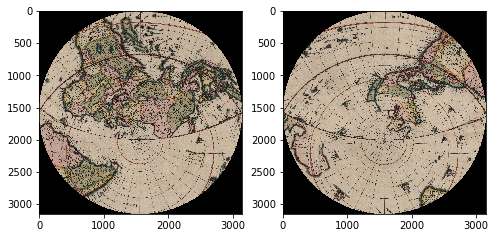

In [223]:
img_test(rot_mat=rotationMatrix(axis_vector=np.array([1.0, 0.0, 0.0]), angle=-np.pi/3))

range of s: -1574.0 to 1574.0
range of t: -1574.0 to 1574.0


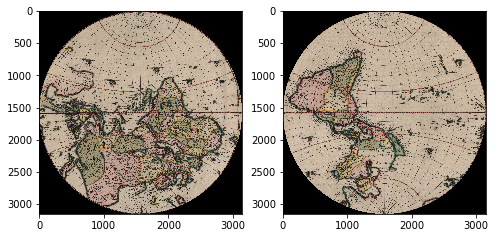

In [206]:
img_test()

In [202]:
def rotationMatrix(axis_vector, angle):
    axis_vector = axis_vector / np.sqrt(sum(axis_vector**2))
    (x, y, z) = axis_vector

    tensor_product_matrix = np.matrix([
            [x**2, x*y, x*z],
            [x*y, y**2, y*z],
            [x*z, y*z, z**2]
        ])
    cross_product_matrix = np.matrix([
            [0.0, -z, y],
            [z, 0.0, -x],
            [-y, x, 0.0]
        ])
    R = np.eye(3) * np.cos(angle) + \
        cross_product_matrix * np.sin(angle) + \
        tensor_product_matrix * (1 - np.cos(angle))

    return R


In [208]:
    full_array = np.array([western_hemisphere, eastern_hemisphere])
    new_full_array = deepcopy(full_array)
    NSs01 = (0.5*(NSs + 1.0)).astype(int)

    
    arr_s, arr_t = uv_to_st(us, vs)
    
    xyzs = st_to_xyz(
        arr_s, arr_t, NSs, 
        radius=hemisphere_pixel_radius
    )
    nxs, nys, nzs = xyzs
    
    new_xxyyzz = np.dot(np.eye(3), np.array([nxs, nys, nzs]))
    nxs = np.squeeze(np.array(new_xxyyzz[0, :]))
    nys = np.squeeze(np.array(new_xxyyzz[1, :]))
    nzs = np.squeeze(np.array(new_xxyyzz[2, :]))

In [209]:
new_xxyyzz.shape

(3, 15585914)